<font color='red' size=5><b> Software Requirements: The below scripts are tested in Python version 3.6.1 and Seaborn version 0.7.1</b> </font><br>   
 
# <font color='blue'>Assignment - Syntactic Analysis - HMMs and Viterbi algorithm for POS tagging</font> <br>
# <font color='blue'> Important Instructions </font>
## <font color='blue'> Setup Working directory, copy files, execute scripts </font>
<font color='blue'> <br>
1) Copy this ipython (ipynb) notebook into your home/working directory <br>
2) Copy the Test_sentences.txt file into your home/working directory <br>
2) Execute below scripts by sequence order </font> <br>

<font color='red' size=5><b>Note: Total execution time is expected to be 16 minutes</font><br>

### Loading all required packages

In [1]:
#Import required libraries
import nltk
import re
import pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize


In [2]:
#Check the python version
from platform import python_version
import seaborn as sns

print(python_version())
print(sns.__version__)

3.6.1
0.7.1


In [3]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

#Print the plot within the page
%matplotlib inline

# Problem Statement

## The vanilla Viterbi algorithm usually resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily.


# Business Goal
### The Objective of this assignment is to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques.

### 1) Classify unknown words into right tag class based morphological clues
### 2) Redefine transition or emission probabilities for unknown words using customized Viterbi algorithm

### -----------------------------------------------------------------------------------------------------------------------------------


In [4]:
# Load Treebank tagged sentences
#Using universal tagset instead of default one for better performance
treebank_corpus = list(nltk.corpus.treebank.tagged_sents(tagset='universal')) 

### Universal POS tags are part-of-speech marks used in Universal Dependencies (UD) which is a project that is developing cross-linguistically consistent treebank annotation for many languages. The annotation scheme is based on an evolution of (universal) Stanford dependencies (de Marneffe et al., 2006, 2008, 2014), Google universal part-of-speech tags (Petrov et al., 2012), and the Interset interlingua for morphosyntactic tagsets (Zeman, 2008).

In [5]:
# let's check some of the tagged data
print(treebank_corpus[1:5])

[[('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('conglomerate', 'NOUN'), ('.', '.')], [('A', 'DET'), ('form', 'NOUN'), ('of', 'ADP'), ('asbestos', 'NOUN'), ('once', 'ADV'), ('used', 'VERB'), ('*', 'X'), ('*', 'X'), ('to', 'PRT'), ('make', 'VERB'), ('Kent', 'NOUN'), ('cigarette', 'NOUN'), ('filters', 'NOUN'), ('has', 'VERB'), ('caused', 'VERB'), ('a', 'DET

In [6]:
#split corpus into training and validation set in the ratio of 95:5

train_set,test_set = train_test_split(treebank_corpus,train_size=0.95,test_size=0.05,random_state = 1011)

In [7]:
#Let us find training and test words
train_tagged_words = [tup for sent in train_set for tup in sent]
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print(len(train_tagged_words))
print(len(test_tagged_words))

95856
4820


In [8]:
#Let's check some of the tagged words from the training set
train_tagged_words[1:5]

[('The', 'DET'), ('son', 'NOUN'), ('of', 'ADP'), ('a', 'DET')]

In [9]:
#Let's check some of the tagged words from the test set
test_tagged_words[1:5]

[',', 'when', 'trading', 'resumes']

In [10]:
#let's see how many unique tags are present in training set
tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)

12
{'VERB', 'ADP', '.', 'PRON', 'DET', 'X', 'NOUN', 'ADV', 'ADJ', 'PRT', 'CONJ', 'NUM'}


In [11]:
#let's find out how many words are present in corpus
words = {word for word,tag in train_tagged_words}
print(len(words))

12039


In [12]:
#Let's find some tokens present in the corpus
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['*-2', 'The', 'son', 'of', 'a', 'specialist', 'and', 'once', 'one', 'himself']

In [13]:
# Set the vocabulary and find the length of the same
V = set(tokens)
print(len(V))

12039


In [14]:
#Set the tags and find the length of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [15]:
#Let's print the tags
print(T)

{'VERB', 'ADP', '.', 'PRON', 'DET', 'X', 'NOUN', 'ADV', 'ADJ', 'PRT', 'CONJ', 'NUM'}


In [16]:
#computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))
print(w_given_t)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [17]:
# Let us now define a function to compute Emission Probability of a given word
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

In [18]:
# Let us now define a function to compute Transition Probability of a given tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# Let's print some examples
print(t2_given_t1(t2='NNP', t1='JJ'))
print(t2_given_t1('NN', 'JJ'))
print(t2_given_t1('NN', 'DT'))
print(t2_given_t1('NNP', 'VB'))
print(t2_given_t1(',', 'NNP'))
print(t2_given_t1('PRP', 'PRP'))
print(t2_given_t1('VBG', 'NNP'))

(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)
(0, 0)


In [20]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DT', '.'))
print(t2_given_t1('VBG', '.'))
print(t2_given_t1('NN', '.'))
print(t2_given_t1('NNP', '.'))


(0, 11128)
(0, 11128)
(0, 11128)
(0, 11128)


In [21]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [22]:
#Let's print the tag matrix
tags_matrix

array([[  1.69360459e-01,   9.06349048e-02,   3.51094268e-02,
          3.55734266e-02,   1.34637699e-01,   2.17152581e-01,
          1.11437634e-01,   8.16642195e-02,   6.50375038e-02,
          3.13974172e-02,   5.49068116e-03,   2.25040596e-02],
       [  8.12399760e-03,   1.68893635e-02,   3.92303579e-02,
          6.89470842e-02,   3.24746132e-01,   3.50614637e-02,
          3.23570281e-01,   1.38963126e-02,   1.04649916e-01,
          1.49652595e-03,   9.62052378e-04,   6.24265112e-02],
       [  8.88749138e-02,   9.07620415e-02,   9.39072594e-02,
          6.55104220e-02,   1.74335018e-01,   2.70488858e-02,
          2.21153840e-01,   5.25700934e-02,   4.48418409e-02,
          2.33644852e-03,   5.89503944e-02,   7.96189755e-02],
       [  4.82334882e-01,   2.11213510e-02,   4.03225794e-02,
          7.68049154e-03,   9.60061420e-03,   9.44700465e-02,
          2.12365597e-01,   3.34101394e-02,   7.29646683e-02,
          1.26728108e-02,   5.37634408e-03,   7.68049154e-03],
    

In [23]:
#Let's convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [24]:
#Let's check the head of the dataframe
tags_df.head()

,VERB,ADP,.,PRON,DET,X,NOUN,ADV,ADJ,PRT,CONJ,NUM
VERB,0.169360,0.090635,0.035109,0.035573,0.134638,0.217153,0.111438,0.081664,0.065038,0.031397,0.005491,0.022504
ADP,0.008124,0.016889,0.039230,0.068947,0.324746,0.035061,0.323570,0.013896,0.104650,0.001497,0.000962,0.062427
.,0.088875,0.090762,0.093907,0.065510,0.174335,0.027049,0.221154,0.052570,0.044842,0.002336,0.058950,0.079619
PRON,0.482335,0.021121,0.040323,0.007680,0.009601,0.094470,0.212366,0.033410,0.072965,0.012673,0.005376,0.007680
DET,0.039837,0.009119,0.017999,0.003360,0.005640,0.045836,0.638829,0.012959,0.203504,0.000240,0.000480,0.022198


In [25]:
#Let's check the location
tags_df.loc['.', :]

VERB    0.088875
ADP     0.090762
.       0.093907
PRON    0.065510
DET     0.174335
X       0.027049
NOUN    0.221154
ADV     0.052570
ADJ     0.044842
PRT     0.002336
CONJ    0.058950
NUM     0.079619
Name: ., dtype: float32

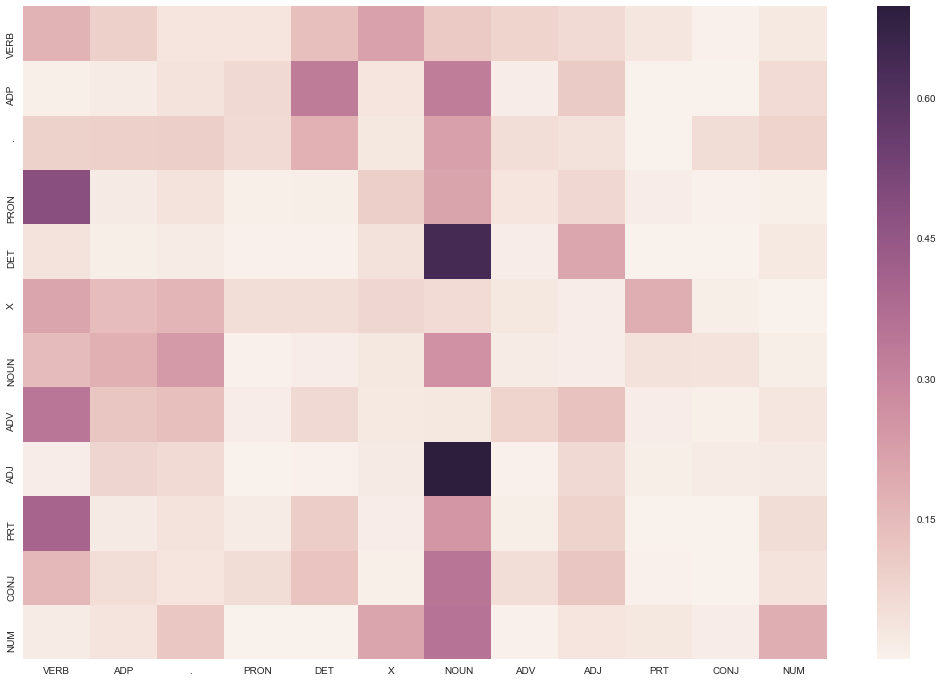

In [26]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

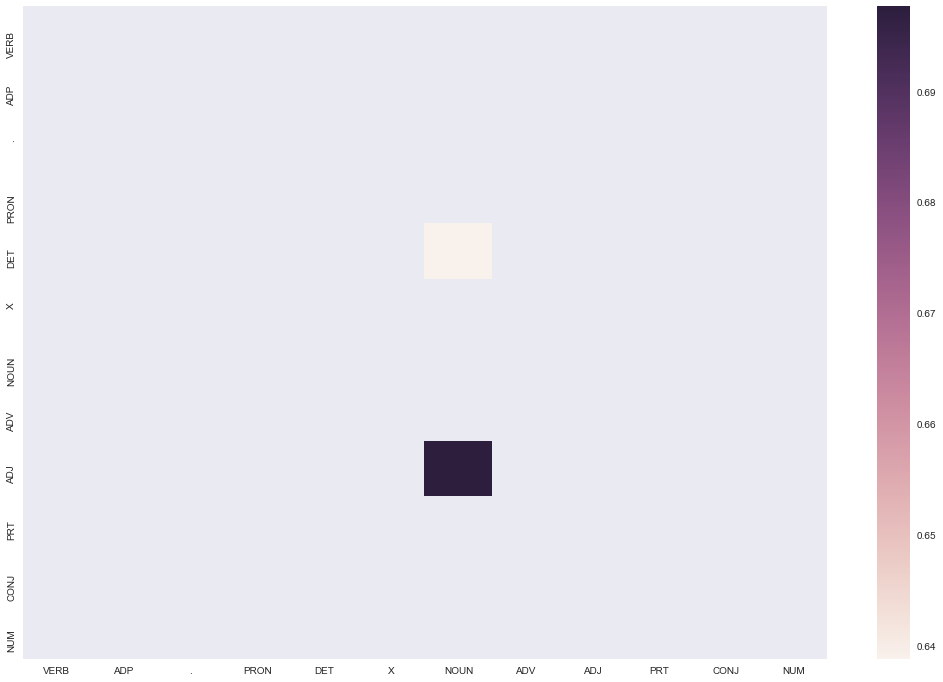

In [27]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [28]:
#Let create a function to define Vanilla Viterbi Algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

## Evaluating on Test Set using Viterbi Algorithm


In [29]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('For', 'ADP'),
  ('fiscal', 'ADJ'),
  ('1989', 'NUM'),
  (',', '.'),
  ('the', 'DET'),
  ('company', 'NOUN'),
  ('posted', 'VERB'),
  ('net', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('734.9', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('or', 'CONJ'),
  ('$', '.'),
  ('2.87', 'NUM'),
  ('*U*', 'X'),
  ('a', 'DET'),
  ('share', 'NOUN'),
  (',', '.'),
  ('down', 'ADP'),
  ('from', 'ADP'),
  ('$', '.'),
  ('811.9', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('or', 'CONJ'),
  ('$', '.'),
  ('3.04', 'NUM'),
  ('*U*', 'X'),
  ('a', 'DET'),
  ('share', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('fiscal', 'ADJ'),
  ('1988', 'NUM'),
  ('.', '.')],
 [('Earlier', 'ADV'),
  ('this', 'DET'),
  ('year', 'NOUN'),
  ('Shaw', 'NOUN'),
  ('Publishing', 'NOUN'),
  ('Inc.', 'NOUN'),
  (',', '.'),
  ('Charlotte', 'NOUN'),
  (',', '.'),
  ('acquired', 'VERB'),
  ('30', 'NUM'),
  ('%', 'NOUN'),
  ('of', 'ADP'),
  ('American', 'NOUN'),
  ('City', 'NOUN'),
  ('*T*-1', 

In [30]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',accuracy*100)

Time taken in seconds:  88.85639786720276
Vanilla Viterbi Algorithm Accuracy:  92.66666666666666


### The Vanilla Viterbi Algorithm, the accuracy is 92% with loss of 8%. We will try to improve the accuracy by various techniques for tagging the words correctly

In [31]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('net', 'ADJ'), ('net', 'NOUN')),
 (('734.9', 'VERB'), ('734.9', 'NUM')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('811.9', 'VERB'), ('811.9', 'NUM')),
 (('3.04', 'VERB'), ('3.04', 'NUM')),
 (('Earlier', 'ADJ'), ('Earlier', 'ADV')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('E.W.', 'VERB'), ('E.W.', 'NOUN')),
 (('Scripps', 'VERB'), ('Scripps', 'NOUN')),
 (('next', 'ADP'), ('next', 'ADJ')),
 (('*-149', 'VERB'), ('*-149', 'X'))]

## Now check the accuracy for the given sentences

In [32]:
f = open('Test_sentences.txt')
text = f.read()
sample_test_sent = text.splitlines()
f.close()

In [33]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]


In [34]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

In [35]:
print("Time taken in seconds: ", difference)
print(sample_tagged_seq)
print(difference)

Time taken in seconds:  90.67453694343567
[('Android', 'VERB'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'VERB'), ('Android', 'VERB'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'VERB'), ('worldwide', 'VERB'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'VERB'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'VERB'), ('Google', 'VERB'), ('and', 'CONJ'), ('Twitter', 'VERB'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'VERB'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'VERB'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'VERB'), ('firehose.', 'VERB'), ('Twitter', 'VERB'), ('is', 'VERB'), ('an', 'DET'), ('online', 'VERB'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('

### We can clearly see words such as Android, Google, Twitter are tagged incorrectly

In [36]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(sample_tagged_seq, test_run_base)) if j[0] != j[1]]

[(('Android', 'VERB'), ('For', 'ADP')),
 (('is', 'VERB'), ('fiscal', 'ADJ')),
 (('a', 'DET'), ('1989', 'NUM')),
 (('mobile', 'ADJ'), (',', '.')),
 (('operating', 'NOUN'), ('the', 'DET')),
 (('system', 'NOUN'), ('company', 'NOUN')),
 (('developed', 'VERB'), ('posted', 'VERB')),
 (('by', 'ADP'), ('net', 'NOUN')),
 (('Google.', 'VERB'), ('of', 'ADP')),
 (('Android', 'VERB'), ('$', '.')),
 (('has', 'VERB'), ('734.9', 'NUM')),
 (('been', 'VERB'), ('million', 'NUM')),
 (('the', 'DET'), ('*U*', 'X')),
 (('best-selling', 'ADJ'), (',', '.')),
 (('OS', 'VERB'), ('or', 'CONJ')),
 (('worldwide', 'VERB'), ('$', '.')),
 (('on', 'ADP'), ('2.87', 'NUM')),
 (('smartphones', 'VERB'), ('*U*', 'X')),
 (('since', 'ADP'), ('a', 'DET')),
 (('2011', 'VERB'), ('share', 'NOUN')),
 (('and', 'CONJ'), (',', '.')),
 (('on', 'ADP'), ('down', 'ADP')),
 (('tablets', 'NOUN'), ('from', 'ADP')),
 (('since', 'ADP'), ('$', '.')),
 (('2013.', 'VERB'), ('811.9', 'NUM')),
 (('Google', 'VERB'), ('million', 'NUM')),
 (('and', '

## Solve the problem of unknown words
### Based on the above observation , we can clearly see that many of the unknown words are tagged incorrectly. We can set the emission probability of unknown word to zero based on transition probabilities
## -------------------------------------------------------------------------------------------------------------

## Technique#1 : Setting emission probability based on transition probabilities

In [37]:
# Based on transition probability of tags when emission probability is zero for unknown words
#Version#1 of Viterbi

def ViterbiV1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
        #Modified version here
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [38]:
#Using the modified version of Viteribi, let's test the tagging again
start = time.time()
tagged_seq = ViterbiV1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Version1 Accuracy: ',accuracy*100)

Time taken in seconds:  77.42496538162231
Modified Viterbi Version1 Accuracy:  94.0


## The modified version of Viterbi algorithm using the Transition probability to assign emission probability to zero for unknown words improved the accuracy to 94% 

## -----------------------------------------------------------------------------------------------------------------------
## Technique#1 : Adding Tag occurance probability weights technique 
## Let us now apply weights based on the probability of tag occurance to the transition probabilities of tags and then we can use the resulting probability for predicting unknown words. This way it will improve the tagging of unknown words 
## This technique will take into account that some of the POS tags are more likely to occur as compared to others. This is an additional benefit of this technique

In [39]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('VERB', 0.13490026706726757),
 ('ADP', 0.09759430812885996),
 ('.', 0.11609080287097312),
 ('PRON', 0.027165748622934402),
 ('DET', 0.08694291437155734),
 ('X', 0.06565055917209148),
 ('NOUN', 0.2868678017025538),
 ('ADV', 0.03163077950258721),
 ('ADJ', 0.06341804373226506),
 ('PRT', 0.032194124520113505),
 ('CONJ', 0.022585962276748455),
 ('NUM', 0.034958688032048074)]

In [40]:
def ViterbiV2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # Modified this part to use the tag_prob. This will find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [41]:
# tagging the test sentences
start = time.time()
# Using the version 2 of the Viterbi algorithm
tagged_seq = ViterbiV2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified ViterbiV2 Accuracy: ',accuracy*100)

Time taken in seconds:  88.25600385665894
Modified ViterbiV2 Accuracy:  94.0


## The accuracy of version2 of the modified Viterbi algorithm is almost same as the Version1
## Let us find incorrectly tagged words

In [42]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('net', 'ADJ'), ('net', 'NOUN')),
 (('734.9', 'NOUN'), ('734.9', 'NUM')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('811.9', 'NOUN'), ('811.9', 'NUM')),
 (('3.04', 'NOUN'), ('3.04', 'NUM')),
 (('Earlier', 'ADJ'), ('Earlier', 'ADV')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('next', 'ADP'), ('next', 'ADJ')),
 (('*-149', 'NOUN'), ('*-149', 'X'))]

In [43]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = ViterbiV2(sample_test_words)
end = time.time()
difference = end-start

In [44]:
print("Time taken in seconds: ", difference)
print(sample_tagged_seq)
print(difference)

Time taken in seconds:  83.24540138244629
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013.', 'NOUN'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ("Twitter's", 'NOUN'), ('firehose.', 'NOUN'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('

## We can see that for the given sentence, the tagging of words are much better than the vanilla Viterbi algorithm 

## ---------------------------------------------------------------------------------------------------------------------------
## Technique#2 : Rule based tagger for unknown words
### We will define array of patterns for the tagger to identify words based on the given patterns. If the pattern matches during tagging process, the word will be tagged accordingly. This will be much more effiective way of handling unknown words

In [45]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense words
    (r'.*es$', 'VERB'),               # verb words  
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'\*T?\*?-[0-9]+$', 'X'),        # X , others
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [46]:
def ViterbiV3(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        p_transition =[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
			# Modified this part to use the tag_prob. This will find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        #rule based tagger included
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            #rule based tagger included
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [47]:
# tagging the test sentences
start = time.time()
tagged_seq = ViterbiV3(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  70.81165218353271


In [48]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 Accuracy: ',accuracy*100)

Modified Viterbi_2 Accuracy:  96.66666666666667


In [49]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('net', 'ADJ'), ('net', 'NOUN')),
 (('down', 'ADV'), ('down', 'ADP')),
 (('Earlier', 'ADJ'), ('Earlier', 'ADV')),
 (('American', 'ADJ'), ('American', 'NOUN')),
 (('next', 'ADP'), ('next', 'ADJ'))]

In [50]:
# modified Viterbi
def ViterbiV4(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [51]:
# tagging the test sentences
start = time.time()
tagged_seq = ViterbiV4(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  86.45504760742188


In [52]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

Modified Viterbi Algorithm Accuracy:  96.66666666666667


In [53]:
file_name = open('Test_sentences.txt')

In [54]:
text = file_name.read()

In [55]:
sample_test_sent = text.splitlines()

In [56]:
file_name.close()

In [57]:
# list of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]

In [58]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  188.51957178115845


In [59]:
sample_tagged_seq

[('Android', 'VERB'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'VERB'),
 ('Android', 'VERB'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'VERB'),
 ('worldwide', 'VERB'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'VERB'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'VERB'),
 ('Google', 'VERB'),
 ('and', 'CONJ'),
 ('Twitter', 'VERB'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'VERB'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'VERB'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'VERB'),
 ('firehose.', 'VERB'),
 ('Twitter', 'VERB'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'VERB'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'D

In [60]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = ViterbiV3(sample_test_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  148.34133505821228


In [61]:
sample_tagged_seq


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

In [62]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

In [63]:
print(tagged_seq)
print(difference)

[('Twitter', 'VERB'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'VERB'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'VERB'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]
16.62952494621277


In [64]:
## Testing
sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = ViterbiV3(words)
end = time.time()
difference = end-start

In [65]:
print(tagged_seq)
print(difference)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('best', 'ADJ'), ('networking', 'NOUN'), ('social', 'ADJ'), ('site', 'NOUN'), ('.', '.'), ('Man', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('social', 'ADJ'), ('animal', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('emerging', 'VERB'), ('field', 'NOUN'), ('.', '.'), ('Data', 'NOUN'), ('science', 'NOUN'), ('jobs', 'NOUN'), ('are', 'VERB'), ('high', 'ADJ'), ('in', 'ADP'), ('demand', 'NOUN'), ('.', '.')]
15.437719106674194


## ViterbiV3 is able to tag the words from the given sentance correctly for the following words:
### Android as NOUN
### Google as NOUN
### Operating as NOUN
### System as NOUN
### Twitter as NOUN

## Accuracy of vanilla Viterbi algorithm is around 92%
## Accuracy of modified Viterbi algorithm is around 96%
### This can clearly shows that the modified Viterbi algorithm with morphological clues and Redefining transition/emission probabilities techniques are better in performance of tagging the words correctly

### End of assignment